In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json

from rich import print
from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags, cross_section, EventSelection

import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from particle import Particle
from scipy.optimize import curve_fit


shower_merging.SetPlotStyle(extend_colors = True, dpi = 140)

In [2]:
config = "work/2023/cex_analysis_1GeV_config.json"
if not config:
    mc = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP)

    beam_quality_fits = {
        "mc" : "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json",
        "data" : "work/2023/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_fit_values.json"
    }
else:
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = 1000)
    data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = 1000)
    beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

samples = {"mc" : mc, "data": data}


# for f in beam_quality_fits:
#     with open(beam_quality_fits[f], "r") as file:
#         beam_quality_fits[f] = json.load(file)

def FilterSamples(samples : dict, masks : dict, PFO : bool = False):
    for s in samples:
        if PFO:
            samples[s].Filter([masks[s]])
        else:
            samples[s].Filter([masks[s]], [masks[s]])

end=False
flat_array=False
mask=<Array [[True, True], ... [True, True]] type='1000 * var * bool'>
end=False
flat_array=False
mask=<Array [[True, True, True, True, ... True], []] type='1000 * var * bool'>


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1126: RuntimeWarning: invalid value encountered in divide
  h_mc = np.sum(h_mc, axis = 0)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1127: RuntimeWarning: invalid value encountered in divide
  


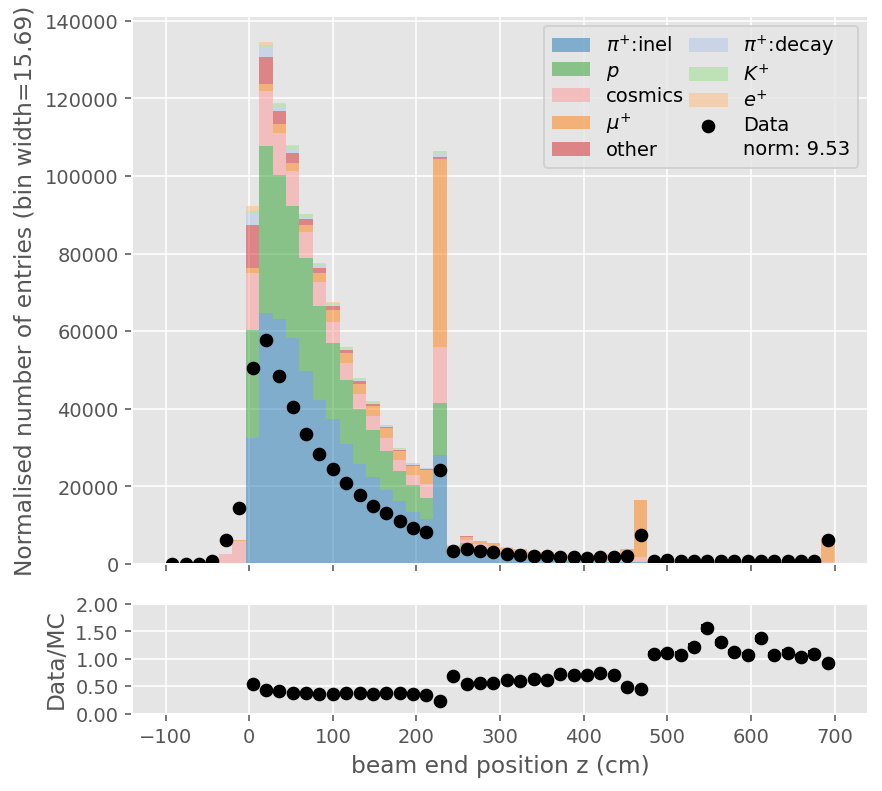

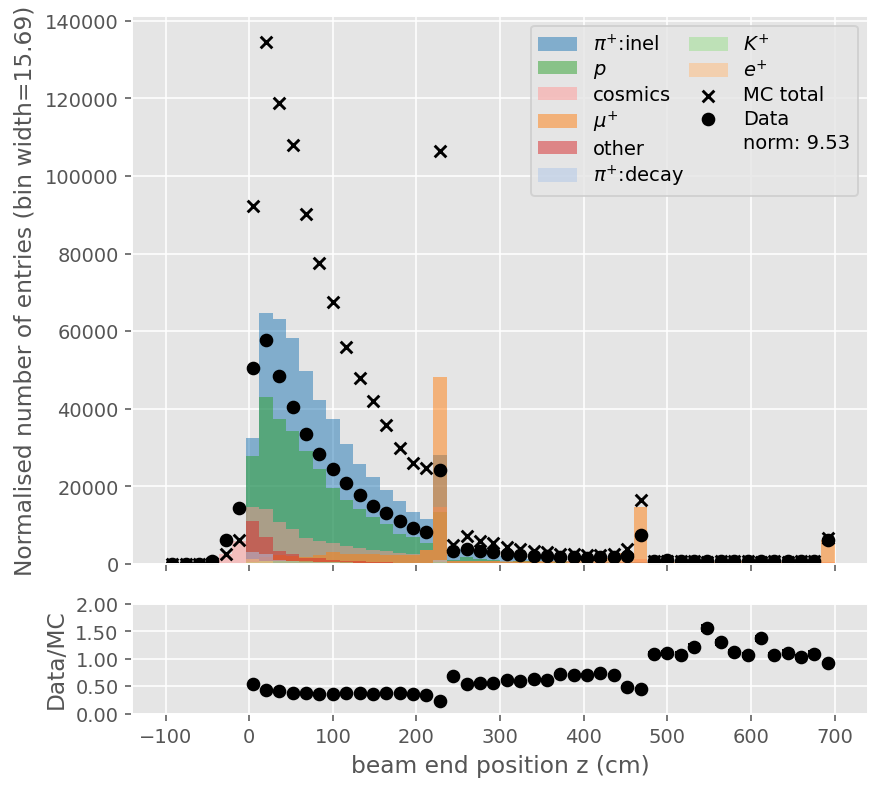

In [42]:
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = True, alpha = 0.5)
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = False, alpha = 0.5)
# Plots.PlotTagged(mc.trueParticles.endPos.z[:, 0], Tags.GenerateTrueBeamParticleTags(mc), x_range = [-100, 700], norm = True, bins = 50, x_label = "true beam end position z (cm)")

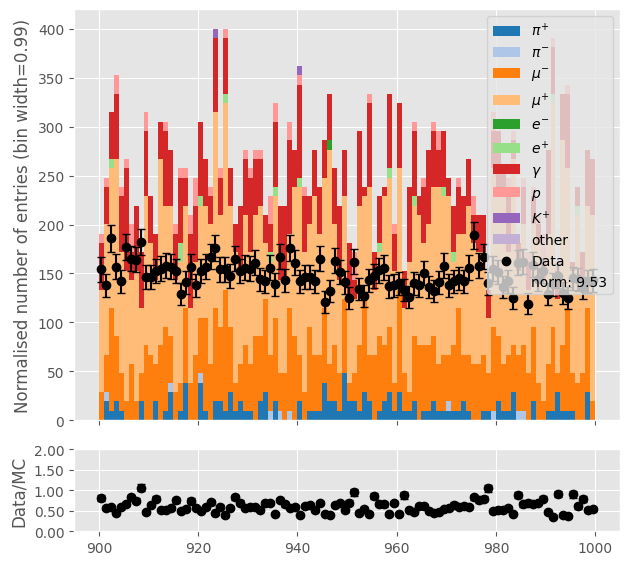

In [5]:
event_normalisation = ak.count(data.eventNum) / ak.count(mc.eventNum)
pfo_normalisation = ak.count(data.recoParticles.number) / ak.count(mc.recoParticles.number)
Plots.PlotTagged(mc.recoParticles.energy, Tags.GenerateTrueParticleTags(mc), data2 = data.recoParticles.energy, y_scale = "linear", norm = event_normalisation, x_range = [900, 1000])

# Beam Particle Selection

number of entries before|after PiBeamSelection: 1000|598
number of entries before|after PiBeamSelection: 1000|351


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


end=False
flat_array=True
mask=<Array [True, True, False, ... False, True] type='1000 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... False, True] type='1000 * bool'>
mask=<Array [True, True, False, ... False, True] type='1000 * bool'>
end_sig=(598, -1)
end=False
flat_array=True
mask=<Array [False, True, False, ... True, True] type='1000 * bool'>
end=True
flat_array=True
mask=<Array [False, True, False, ... True, True] type='1000 * bool'>
mask=<Array [False, True, False, ... True, True] type='1000 * bool'>
end_sig=(351, -1)


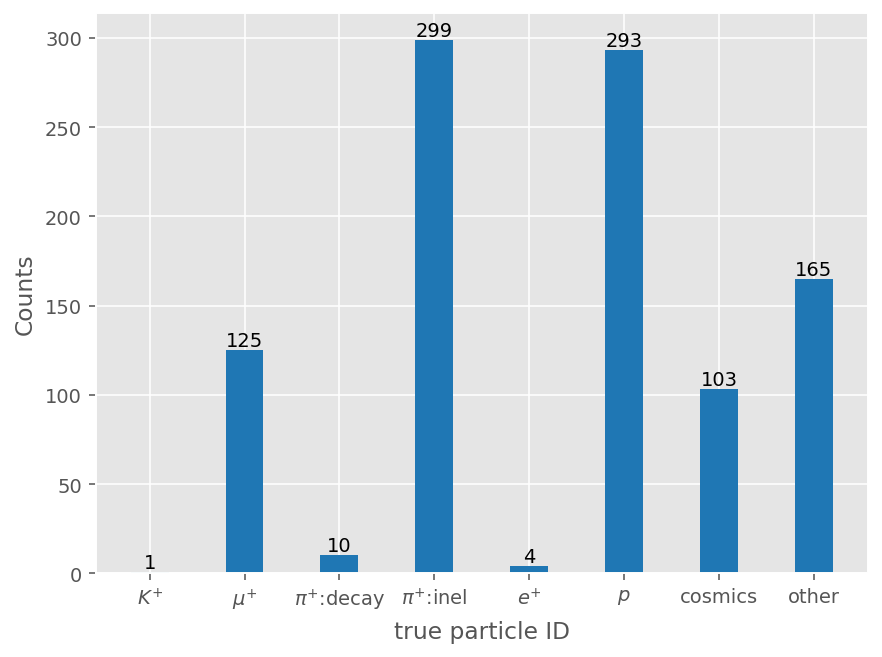

In [3]:
masks = {
    "mc" : BeamParticleSelection.PiBeamSelection(samples["mc"]),
    "data" : BeamParticleSelection.PiBeamSelection(samples["data"], use_beam_inst = True)
}

counts = Tags.GenerateTrueBeamParticleTags(samples["mc"])
for i in counts:
    counts[i] = ak.sum(counts[i].mask)

bar_data = []
for tag in counts:
    bar_data.extend([tag]*counts[tag])
Plots.PlotBar(bar_data, xlabel = "true particle ID")

FilterSamples(samples, masks)

In [4]:
masks = {s : BeamParticleSelection.CaloSizeCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

number of entries before|after CaloSizeCut: 598|528
number of entries before|after CaloSizeCut: 351|320
end=False
flat_array=True
mask=<Array [True, True, False, ... True, True] type='598 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... True, True] type='598 * bool'>
mask=<Array [True, True, False, ... True, True] type='598 * bool'>
end_sig=(528, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='351 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='351 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='351 * bool'>
end_sig=(320, -1)


number of entries before|after PandoraTagCut: 528|514
number of entries before|after PandoraTagCut: 320|309
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='528 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='528 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='528 * bool'>
end_sig=(514, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='320 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='320 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='320 * bool'>
end_sig=(309, -1)


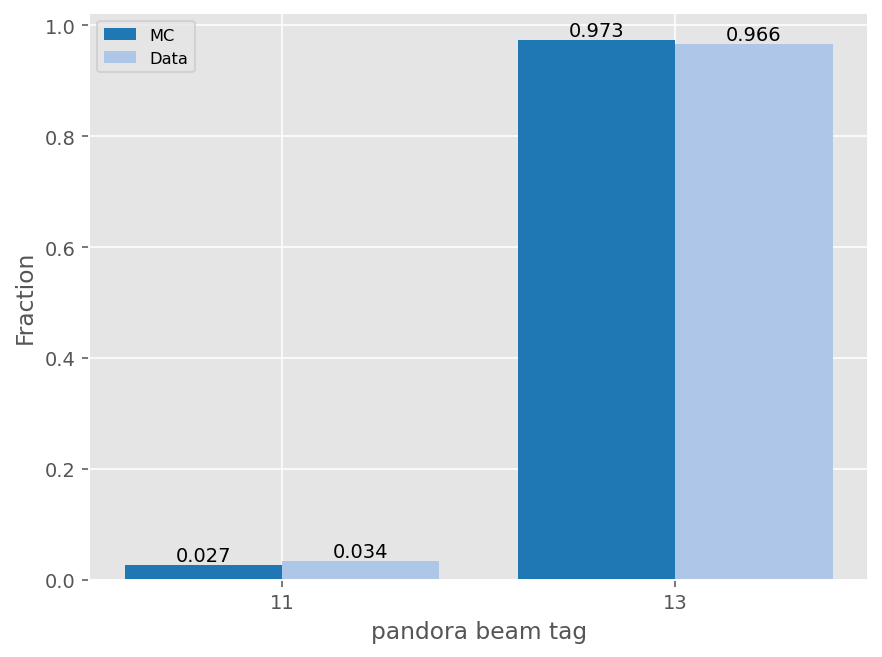

In [5]:
masks = {s : BeamParticleSelection.PandoraTagCut(samples[s]) for s in samples}

if data is None:
    Plots.PlotBar(samples["mc"])
else:
    Plots.PlotBarComparision(samples["mc"].recoParticles.beam_pandora_tag, samples["data"].recoParticles.beam_pandora_tag, label_1 = "MC", label_2 = "Data", xlabel = "pandora beam tag", fraction = True, barlabel = True)

FilterSamples(samples, masks)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1175: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1175: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1176: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


dxy cut: (514, 420)

dxy cut: (309, 241)

end=False
flat_array=True
mask=<Array [True, True, True, ... True, True] type='514 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True] type='514 * bool'>
mask=<Array [True, True, True, ... True, True] type='514 * bool'>
end_sig=(420, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... False, True] type='309 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... False, True] type='309 * bool'>
mask=<Array [True, True, True, ... False, True] type='309 * bool'>
end_sig=(241, -1)


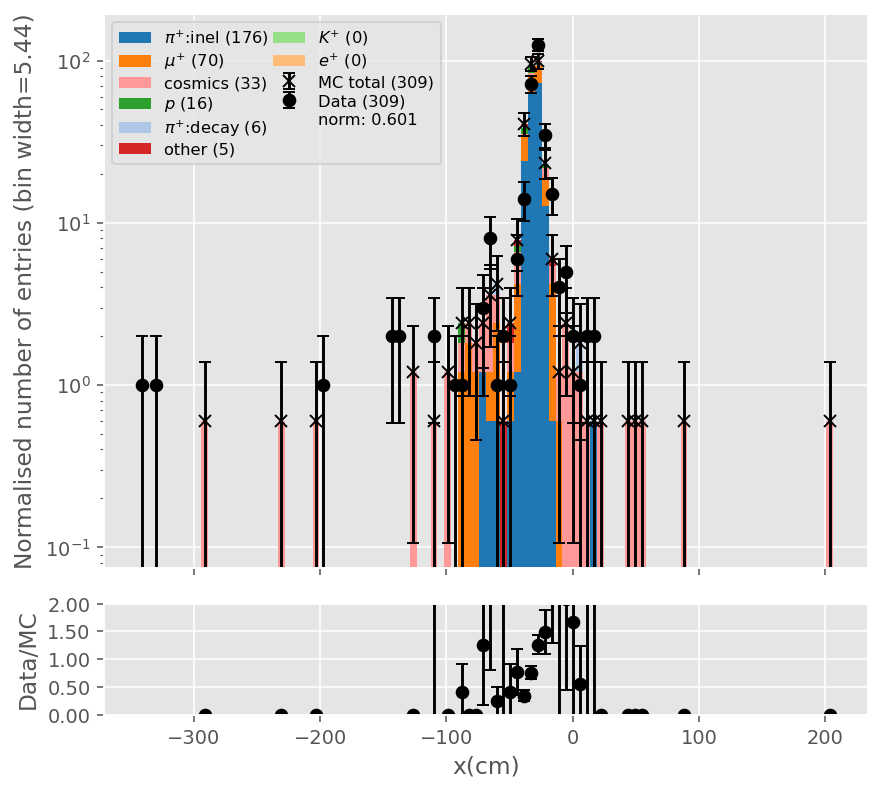

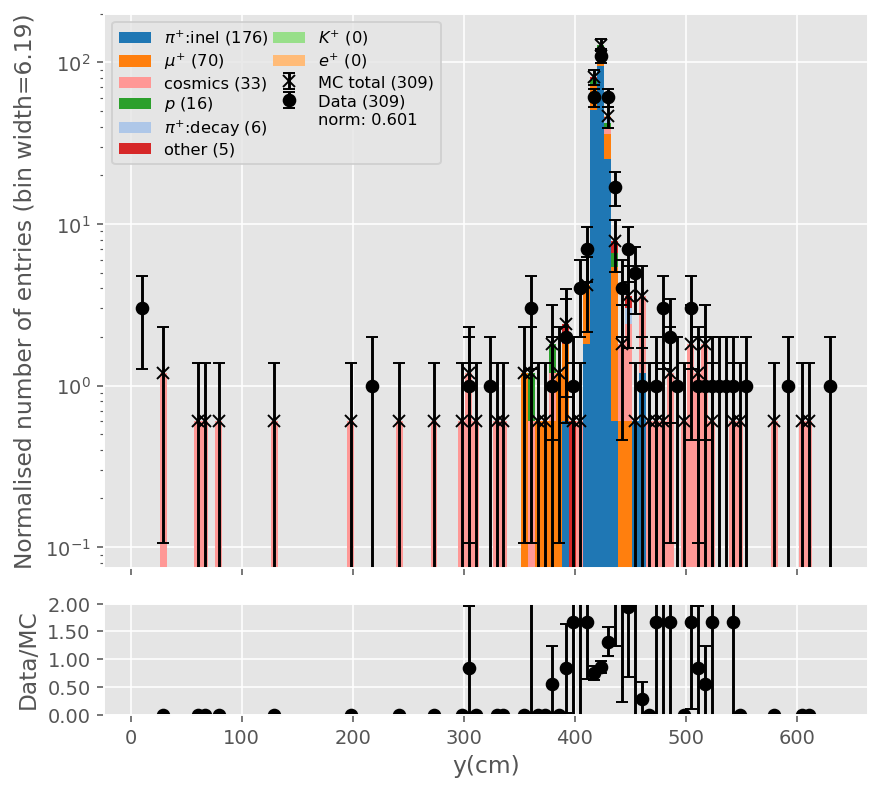

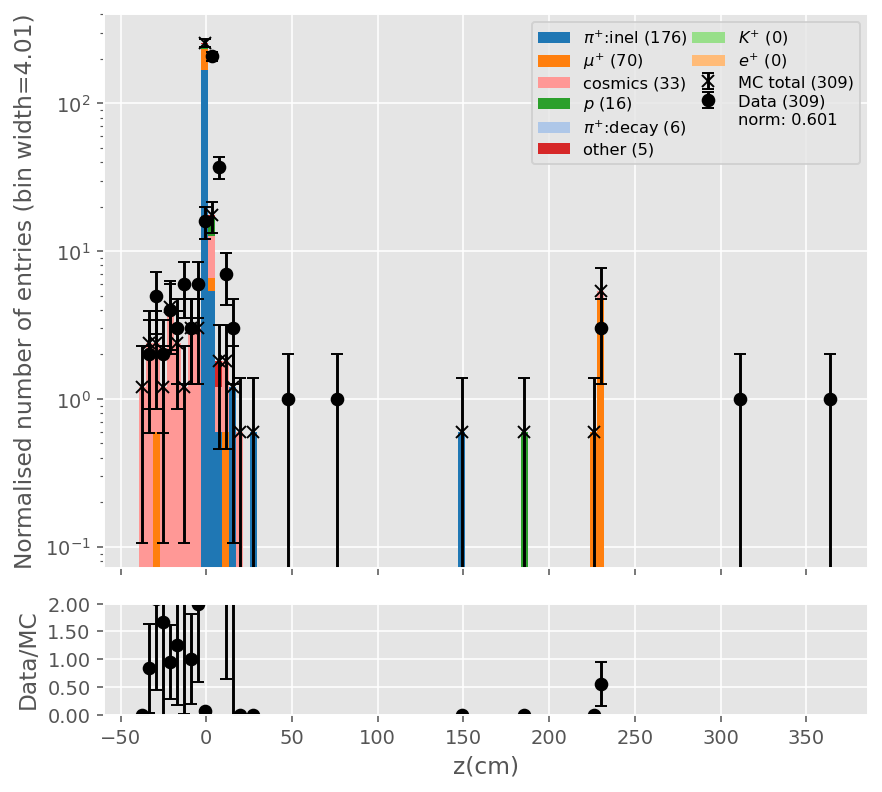

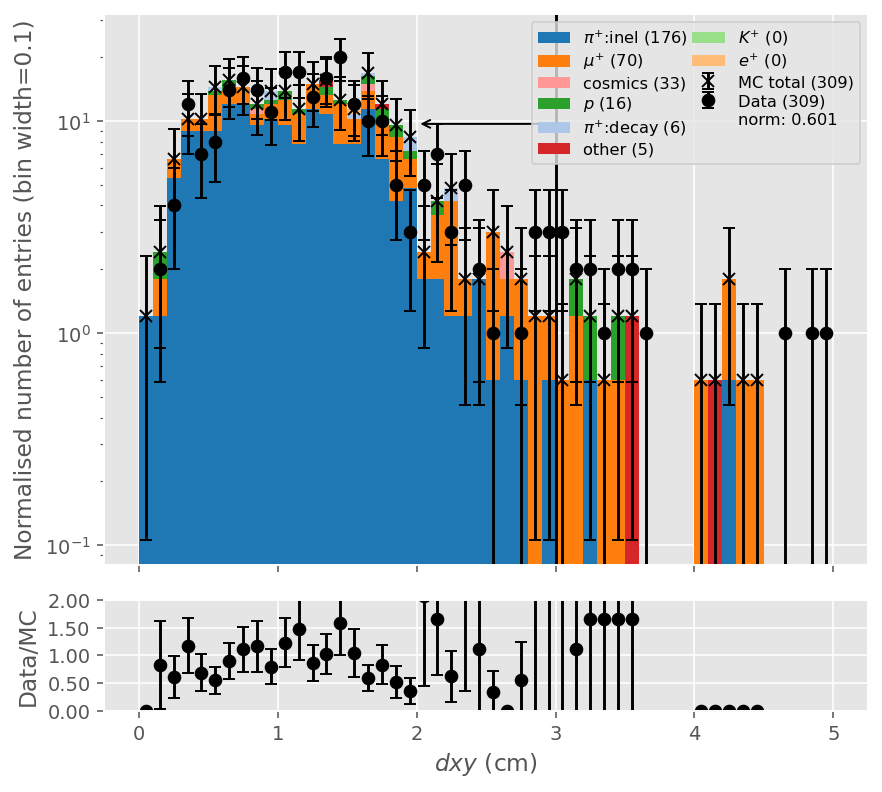

In [6]:
def norm(x, mu, sigma):
    return (x - mu) / sigma

# Beam quality cuts
for i in ["x", "y", "z"]:
    Plots.PlotTagged(mc.recoParticles.beam_startPos_SCE[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_startPos_SCE[i], x_label = i + "(cm)", y_scale = "log", norm = True)

#* dxy cut
dxy = {s : (norm(samples[s].recoParticles.beam_startPos_SCE.x, beam_quality_fits[s]["mu_x"], beam_quality_fits[s]["sigma_x"])**2 + norm(samples[s].recoParticles.beam_startPos_SCE.y, beam_quality_fits[s]["mu_y"], beam_quality_fits[s]["sigma_y"])**2)**0.5 for s in samples}
masks = {s : dxy[s] < 3 for s in samples}

Plots.PlotTagged(dxy["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(dxy["data"]), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 5], norm = True)
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

[print(f"dxy cut: {BeamParticleSelection.CountMask(masks[s])}") for s in masks]
FilterSamples(samples, masks)


end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='420 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='420 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='420 * bool'>
end_sig=(382, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='241 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='241 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='241 * bool'>
end_sig=(232, -1)


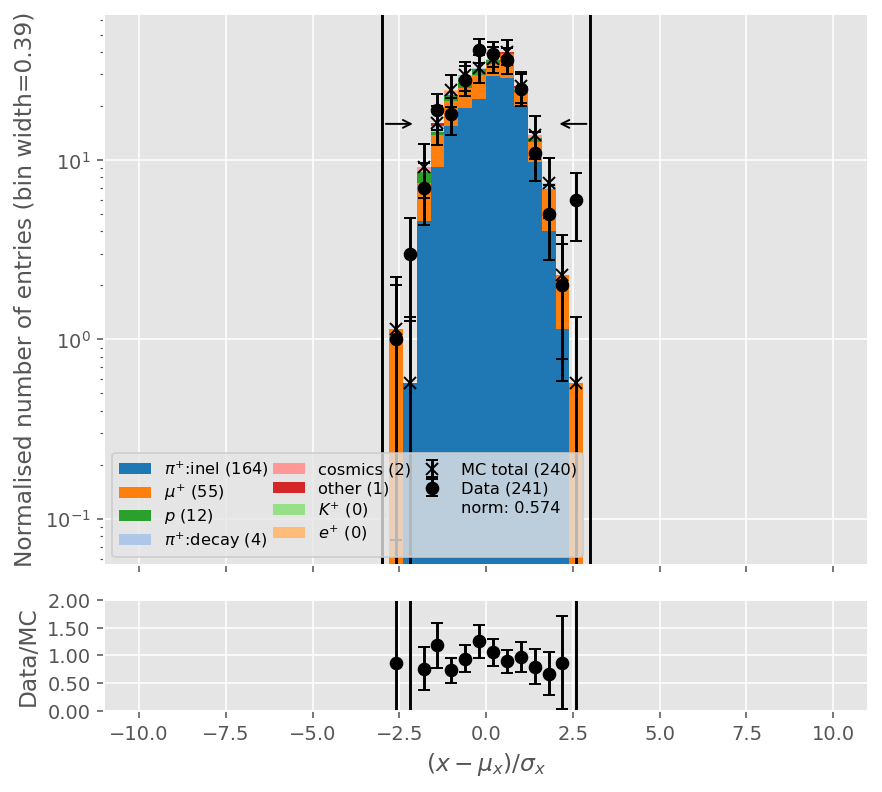

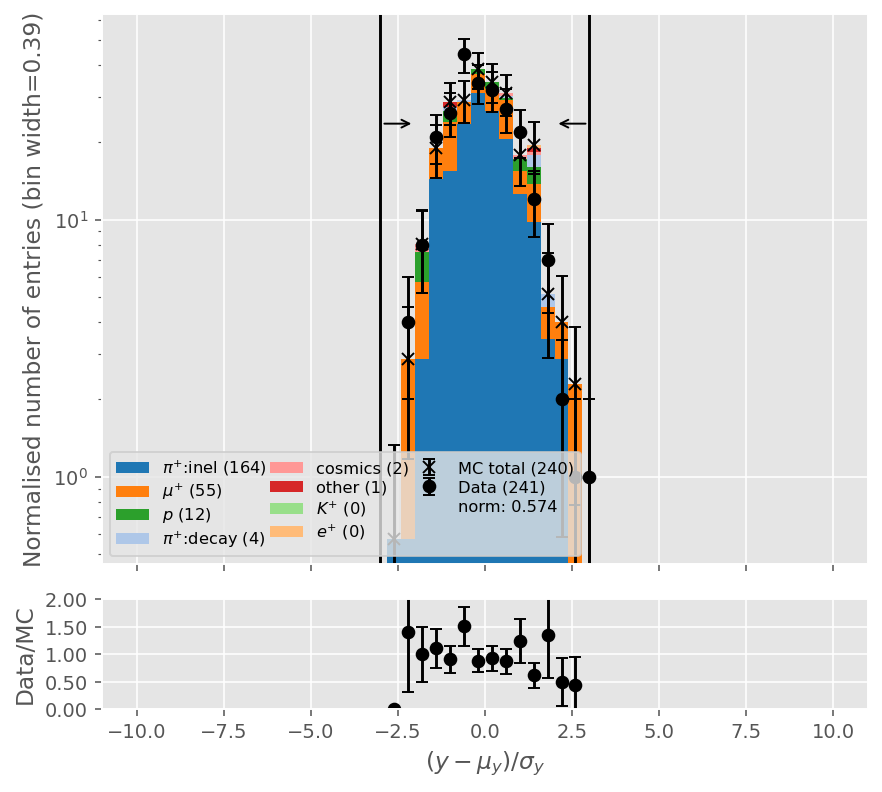

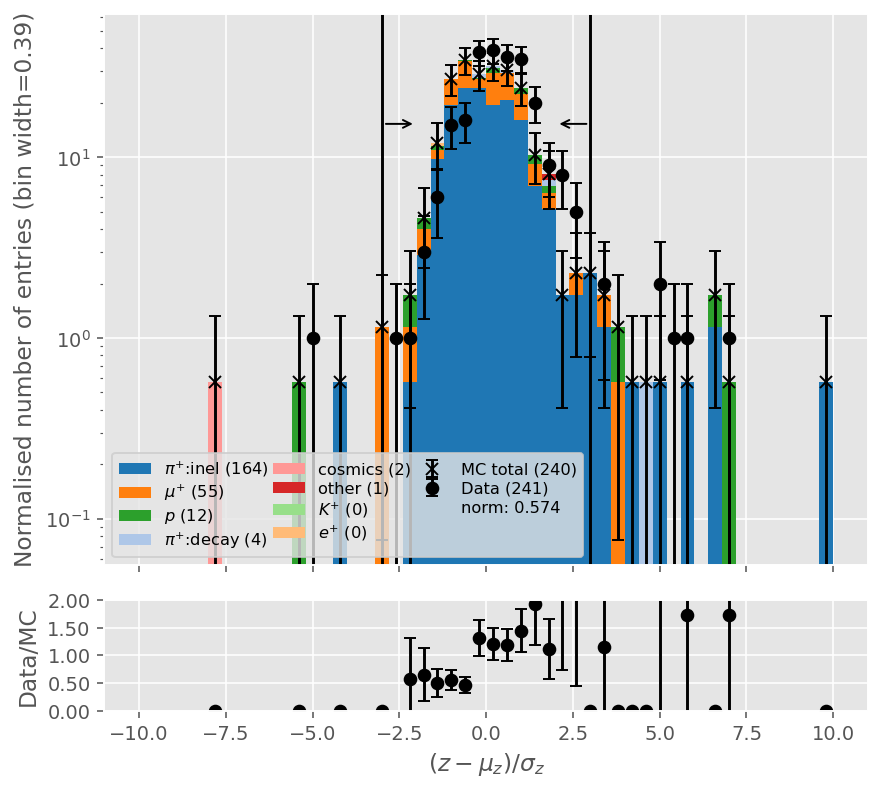

In [7]:
deltas_mc = {}
deltas_data = {}
for i in ["x", "y", "z"]:
    deltas_mc[i] = norm(samples["mc"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["mc"][f"mu_{i}"], beam_quality_fits["mc"][f"sigma_{i}"])
    deltas_data[i] = norm(samples["data"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["data"][f"mu_{i}"], beam_quality_fits["data"][f"sigma_{i}"])
    Plots.PlotTagged(deltas_mc[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(deltas_data[i]), bins = 50, x_range = [-10, 10], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3, norm = True)
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")


masks = {
    "mc" : (deltas_mc["z"] > -3) & (deltas_mc["z"] < 3),
    "data" : (deltas_data["z"] > -3) & (deltas_data["z"] < 3)
}

FilterSamples(samples, masks)

end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='382 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='382 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='382 * bool'>
end_sig=(367, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='232 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='232 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='232 * bool'>
end_sig=(215, -1)


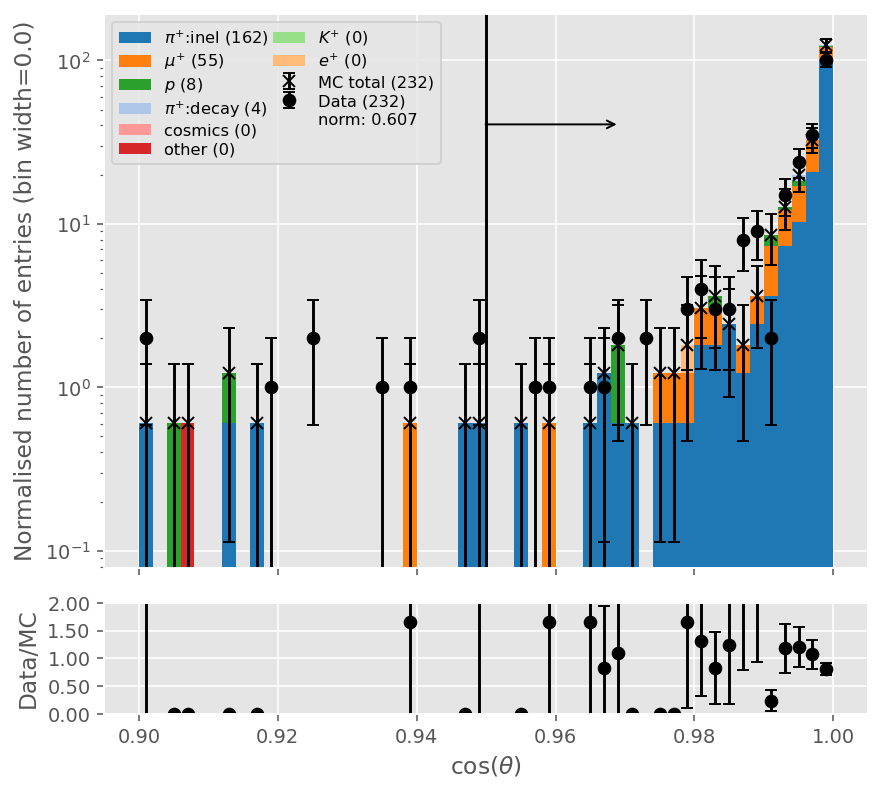

In [8]:
beam_dir = {s : vector.normalize(vector.sub(samples[s].recoParticles.beam_endPos_SCE, samples[s].recoParticles.beam_startPos_SCE)) for s in samples}

beam_dir_mu = {s : vector.normalize(vector.vector(beam_quality_fits[s]["mu_dir_x"], beam_quality_fits[s]["mu_dir_y"], beam_quality_fits[s]["mu_dir_z"])) for s in beam_quality_fits}

beam_costh = {s : vector.dot(beam_dir[s], beam_dir_mu[s]) for s in beam_dir_mu}

Plots.PlotTagged(beam_costh["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(beam_costh["data"]), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1], norm = True)
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

masks = {s : beam_costh[s] > 0.95 for s in samples}
FilterSamples(samples, masks)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1175: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1175: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1176: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters 

number of entries before|after APA3Cut: 239|209
number of entries before|after APA3Cut: 135|115
end=False
flat_array=True
mask=<Array [True, True, False, ... True, True] type='239 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... True, True] type='239 * bool'>
mask=<Array [True, True, False, ... True, True] type='239 * bool'>
end_sig=(209, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... False, True] type='135 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... False, True] type='135 * bool'>
mask=<Array [True, True, True, ... False, True] type='135 * bool'>
end_sig=(115, -1)


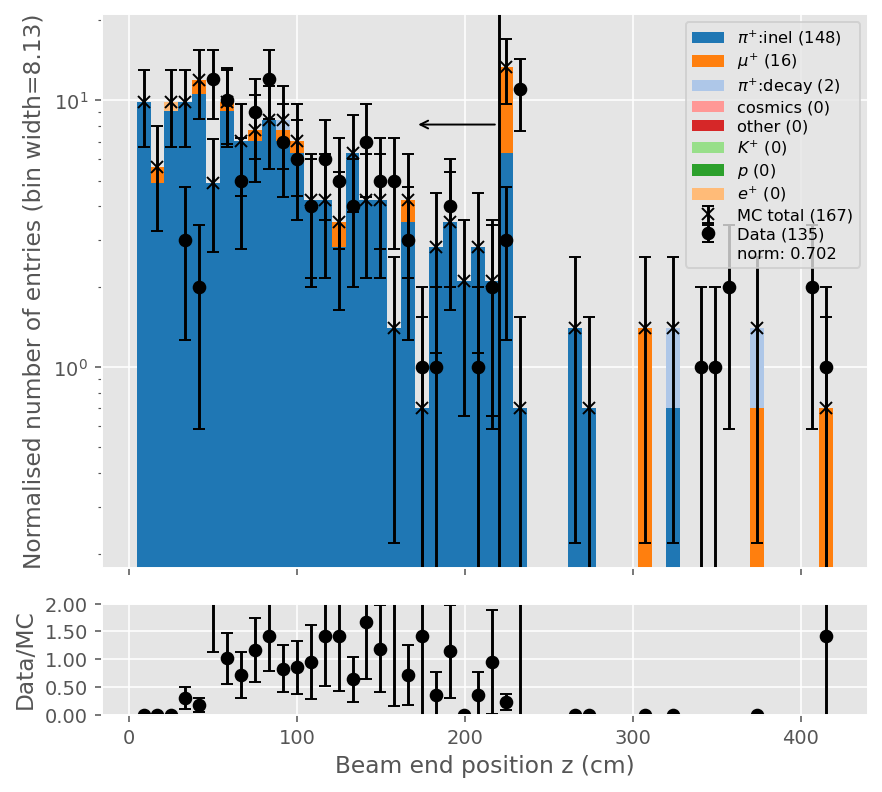

In [14]:
Plots.PlotTagged(samples["mc"].recoParticles.beam_endPos_SCE.z, Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.beam_endPos.z, x_label = "Beam end position z (cm)", norm = args.norm, bins = 50, y_scale = "log", ncols = 1)
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)

masks = {s : BeamParticleSelection.APA3Cut(samples[s]) for s in samples}

FilterSamples(samples, masks)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 367|317
number of entries before|after MichelScoreCut: 215|193
end=False
flat_array=True
mask=<Array [True, True, False, ... True, True] type='367 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... True, True] type='367 * bool'>
mask=<Array [True, True, False, ... True, True] type='367 * bool'>
end_sig=(317, -1)
end=False
flat_array=True
mask=<Array [True, True, False, ... True, True] type='215 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... True, True] type='215 * bool'>
mask=<Array [True, True, False, ... True, True] type='215 * bool'>
end_sig=(193, -1)


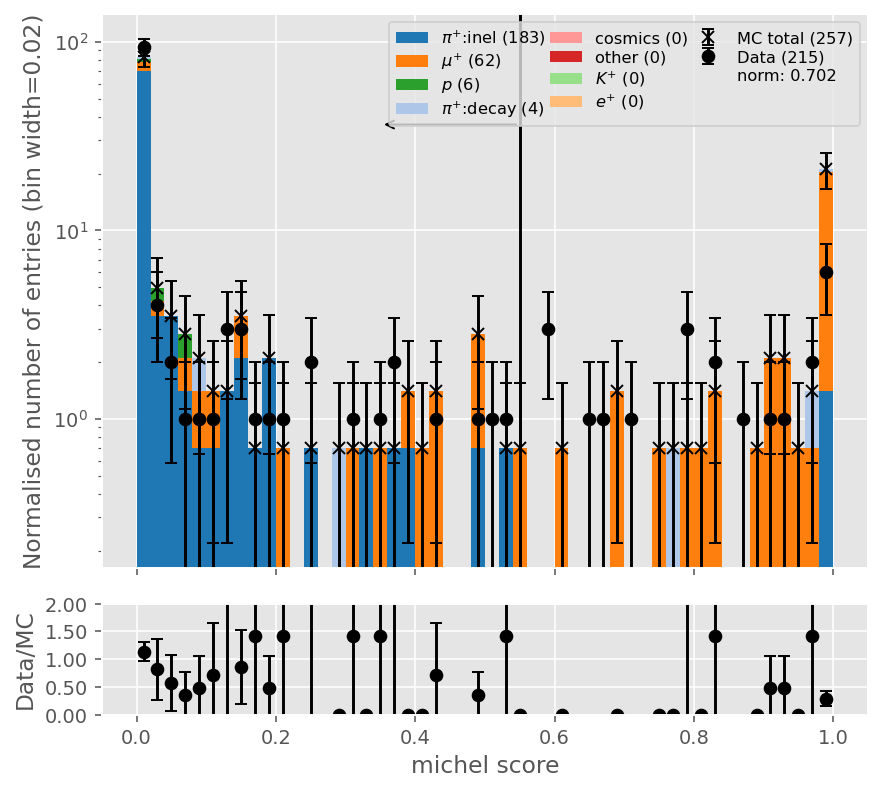

In [9]:
# michel score cut

scores = {}
for s in samples:
    score = ak.where(samples[s].recoParticles.beam_nHits != 0, samples[s].recoParticles.beam_michelScore / samples[s].recoParticles.beam_nHits, -999)
    masks[s] = BeamParticleSelection.MichelScoreCut(samples[s])
    scores[s] = score

Plots.PlotTagged(scores["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = np.array(scores["data"]), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3, norm = args.norm)
Plots.DrawCutPosition(0.55, face = "left")

FilterSamples(samples, masks)

number of entries before|after MedianDEdXCut: 317|305
number of entries before|after MedianDEdXCut: 193|179
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='317 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='317 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='317 * bool'>
end_sig=(305, -1)
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='193 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='193 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='193 * bool'>
end_sig=(179, -1)


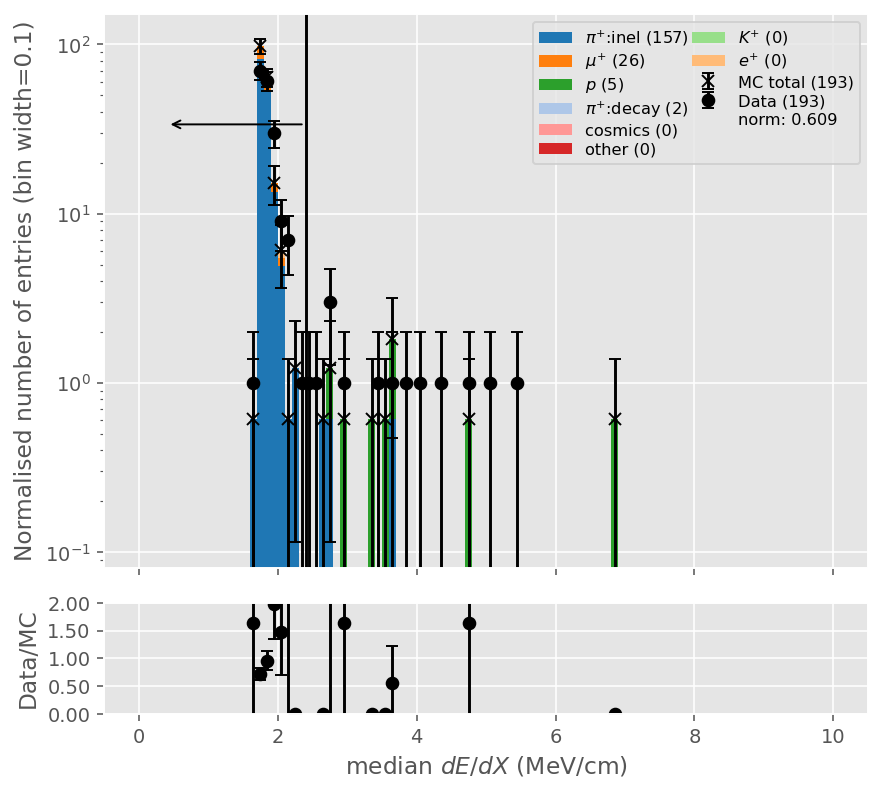

In [10]:
median = {s : PFOSelection.Median(samples[s].recoParticles.beam_dEdX) for s in samples}

Plots.PlotTagged(median["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = median["data"], y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)", norm = True)
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

masks = {s : BeamParticleSelection.MedianDEdXCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

[-0.0534, 1.31, 0.714, -0.616, 0.0352, -0.537, ... -1.7, 0.448, 0.548, -0.0116, 1.21]
[-0.221, -0.919, -0.478, 0.202, -1.03, ... -1.15, -0.201, -0.0576, -0.628, -0.0192]
number of entries before|after BeamScraper: 305|239
[-0.462, 0.729, -2.05, 0.826, -0.19, -0.604, ... 0.336, -0.181, 0.606, -1.18, 0.593]
[0.431, 1.11, 0.647, 0.563, 0.111, 0.454, ... -1.73, 1.18, 0.932, -0.893, 1.01, 1.07]
number of entries before|after BeamScraper: 179|135
end=False
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='305 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, ... True, True, True] type='305 * bool'>
mask=<Array [True, True, True, ... True, True, True] type='305 * bool'>
end_sig=(239, -1)
end=False
flat_array=True
mask=<Array [True, True, False, ... True, True] type='179 * bool'>
end=True
flat_array=True
mask=<Array [True, True, False, ... True, True] type='179 * bool'>
mask=<Array [True, True, False, ... True, True] type='179 * bool'>
end_sig=(135, -1)


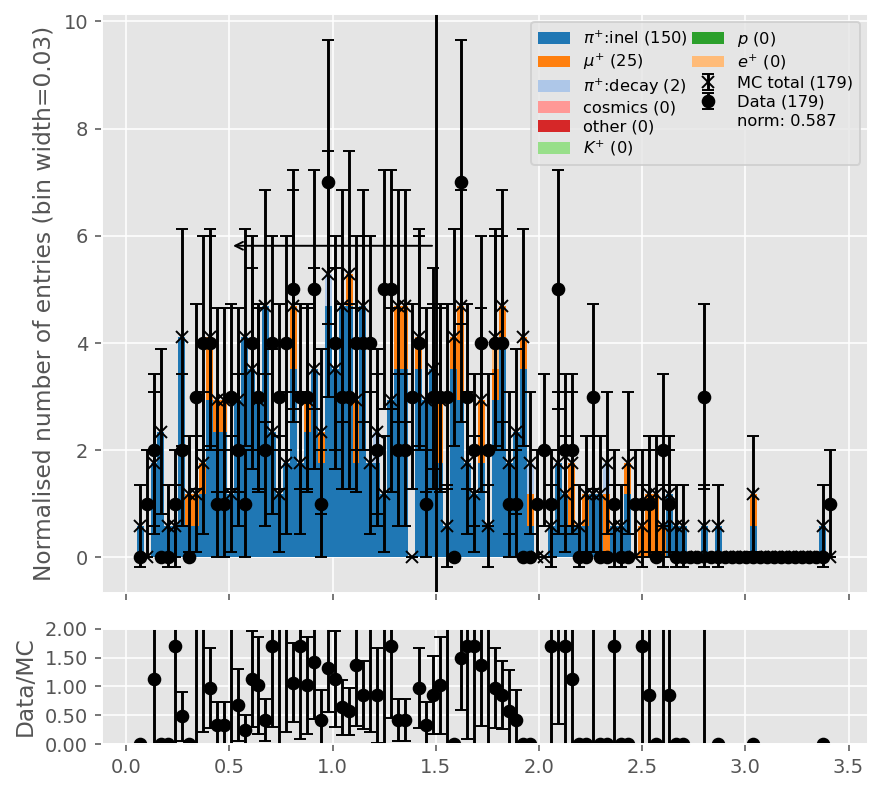

In [11]:
a = {"mc" : "mc_arguments", "data" : "data_arguments"}
masks = {s : BeamParticleSelection.BeamScraper(samples[s], args.beam_selection[a[s]][-1]["KE_range"], args.beam_selection[a[s]][-1]["fits"], args.beam_selection[a[s]][-1]["pdg_hyp"], args.beam_selection[a[s]][-1]["cut"]) for s in samples}

nx = {s : norm(samples[s].recoParticles.beam_inst_pos.x, ak.mean(samples[s].recoParticles.beam_inst_pos.x), ak.std(samples[s].recoParticles.beam_inst_pos.x)) for s in samples}
ny = {s : norm(samples[s].recoParticles.beam_inst_pos.y, ak.mean(samples[s].recoParticles.beam_inst_pos.y), ak.std(samples[s].recoParticles.beam_inst_pos.y)) for s in samples}

r = {s : (nx[s]**2 + ny[s]**2)**0.5 for s in samples}

Plots.PlotTagged(r["mc"], data2 = r["data"], tags = Tags.GenerateTrueBeamParticleTags(samples["mc"]), norm = True)
Plots.DrawCutPosition(args.beam_selection[a[s]][-1]["cut"], arrow_length = 1, face = "left", arrow_loc = 0.6)

FilterSamples(samples, masks)

In [15]:
samples["mc"].cutTable.get_table()

,Name,Remaining events,Percentage of total events remaining,Relative percentage events,Remaining PFOs,Percentage of total PFOs remaining,Relative percentage of PFOs,Average PFOs per event
0,Initial data,1000,100.0,100.000000,1384,100.000000,100.000000,1.384000
1,-,598,59.8,59.800000,1161,83.887283,83.887283,1.941472
2,-,528,52.8,88.294314,1136,82.080925,97.846684,2.151515
3,-,514,51.4,97.348485,1113,80.419075,97.975352,2.165370
4,-,420,42.0,81.712062,827,59.754335,74.303684,1.969048
5,-,382,38.2,90.952381,732,52.890173,88.512696,1.916230
6,-,367,36.7,96.073298,714,51.589595,97.540984,1.945504
7,-,317,31.7,86.376022,635,45.881503,88.935574,2.003155
8,-,305,30.5,96.214511,627,45.303468,98.740157,2.055738
9,-,239,23.9,78.360656,503,36.343931,80.223285,2.104603


In [16]:
samples["data"].cutTable.get_table()

,Name,Remaining events,Percentage of total events remaining,Relative percentage events,Remaining PFOs,Percentage of total PFOs remaining,Relative percentage of PFOs,Average PFOs per event
0,Initial data,1000,100.0,100.000000,1178,100.000000,100.000000,1.178000
1,-,351,35.1,35.100000,743,63.073005,63.073005,2.116809
2,-,320,32.0,91.168091,711,60.356537,95.693136,2.221875
3,-,309,30.9,96.562500,689,58.488964,96.905767,2.229773
4,-,241,24.1,77.993528,483,41.001698,70.101597,2.004149
5,-,232,23.2,96.265560,460,39.049236,95.238095,1.982759
6,-,215,21.5,92.672414,433,36.757216,94.130435,2.013953
7,-,193,19.3,89.767442,412,34.974533,95.150115,2.134715
8,-,179,17.9,92.746114,385,32.682513,93.446602,2.150838
9,-,135,13.5,75.418994,293,24.872666,76.103896,2.170370


# Quick Beam Selection

In [3]:
masks = {}
masks["mc"] = BeamParticleSelection.CreateDefaultSelection(samples["mc"], False, beam_quality_fits["mc"], verbose = False, return_table = False)
masks["data"] = BeamParticleSelection.CreateDefaultSelection(samples["data"], True, beam_quality_fits["data"], verbose = False, return_table = False)
FilterSamples(samples, masks)

masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PandoraTagCut: 141548|123438
number of entries before|after CaloSizeCut: 141548|125589


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 141548|115682
number of entries before|after BeamQualityCut: 141548|82069
number of entries before|after APA3Cut: 141548|120483
number of entries before|after MedianDEdXCut: 141548|131247
number of entries before|after PiBeamSelection: 1349399|285238
number of entries before|after PandoraTagCut: 1349399|508203
number of entries before|after CaloSizeCut: 1349399|587932
number of entries before|after MichelScoreCut: 1349399|496543
number of entries before|after BeamQualityCut: 1349399|273698
number of entries before|after APA3Cut: 1349399|1263147
number of entries before|after MedianDEdXCut: 1349399|1295793


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after ValidRecoPositionCut: 171337|164109
number of entries before|after ValidRecoMomentumCut: 171337|152487
number of entries before|after ValidRecoEnergyCut: 171337|152487
number of entries before|after ValidRecoPositionCut: 449545|428273
number of entries before|after ValidRecoMomentumCut: 449545|396782
number of entries before|after ValidRecoEnergyCut: 449545|396782


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply fil

# Good PFO selection

In [17]:
masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after ValidRecoPositionCut: 452|432
number of entries before|after ValidRecoMomentumCut: 452|399
number of entries before|after ValidRecoEnergyCut: 452|399
number of entries before|after ValidRecoPositionCut: 258|249
number of entries before|after ValidRecoMomentumCut: 258|232
number of entries before|after ValidRecoEnergyCut: 258|232
end=False
flat_array=False
mask=<Array [[True, True], ... [True, True]] type='209 * var * bool'>
end=True
flat_array=False
mask=<Array [[True, True], ... [True, True]] type='209 * var * bool'>
mask=<Array [[True, True], ... [True, True]] type='209 * var * bool'>
end_sig=(209, 399)
end=False
flat_array=False
mask=<Array [[], [True, True, True, ... [False], []] type='115 * var * bool'>
end=True
flat_array=False
mask=<Array [[], [True, True, True, ... [False], []] type='115 * var * bool'>
mask=<Array [[], [True, True, True, ... [False], []] type='115 * var * bool'>
end_sig=(115, 232)


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1

# $\pi^{+}$ Particle Selection

number of entries before|after BeamDaughterCut: 46519|0
number of entries before|after BeamDaughterCut: 117240|0


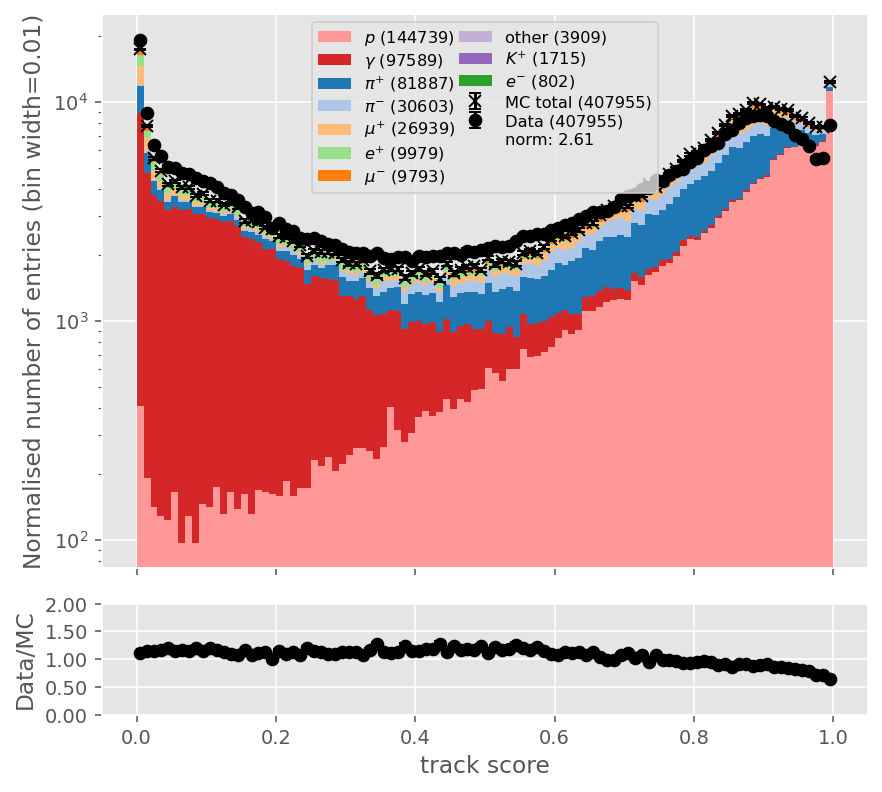

In [4]:
# only for my ntuples
masks = {s : PFOSelection.BeamDaughterCut(samples[s]) for s in samples}
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "log", x_label = "track score", norm = True)


number of entries before|after TrackScoreCut: 156355|100379
number of entries before|after TrackScoreCut: 408436|241511


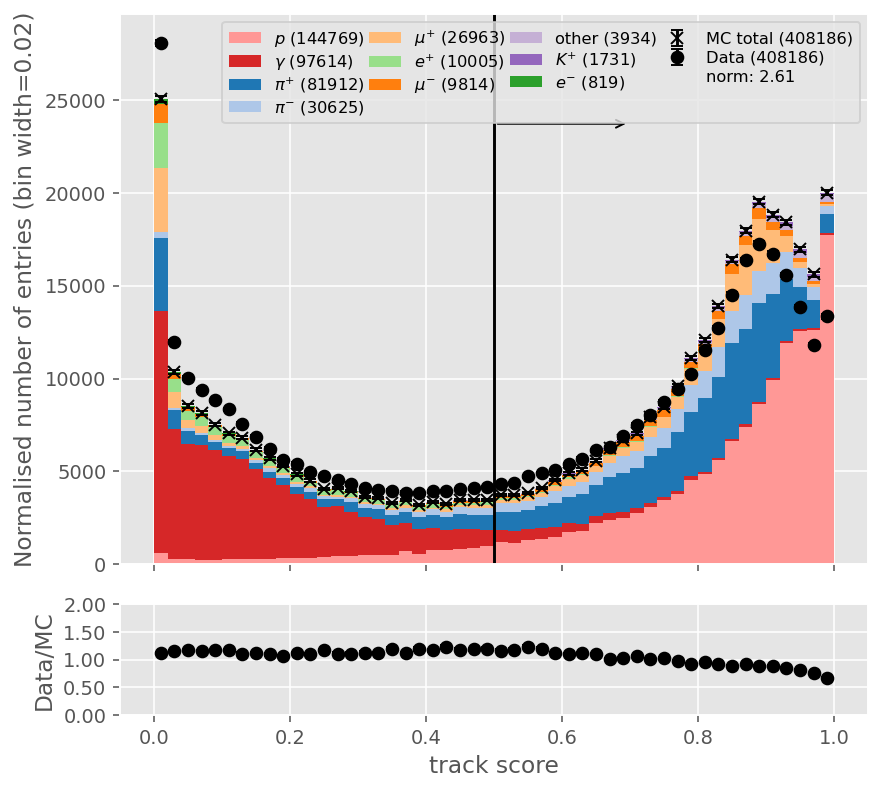

In [4]:
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "linear", bins = 50, ncols = 4, x_label = "track score", norm = True)
Plots.DrawCutPosition(0.5, face = "right")

masks = {s : PFOSelection.TrackScoreCut(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 100379|94725
number of entries before|after NHitsCut: 241511|227140


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

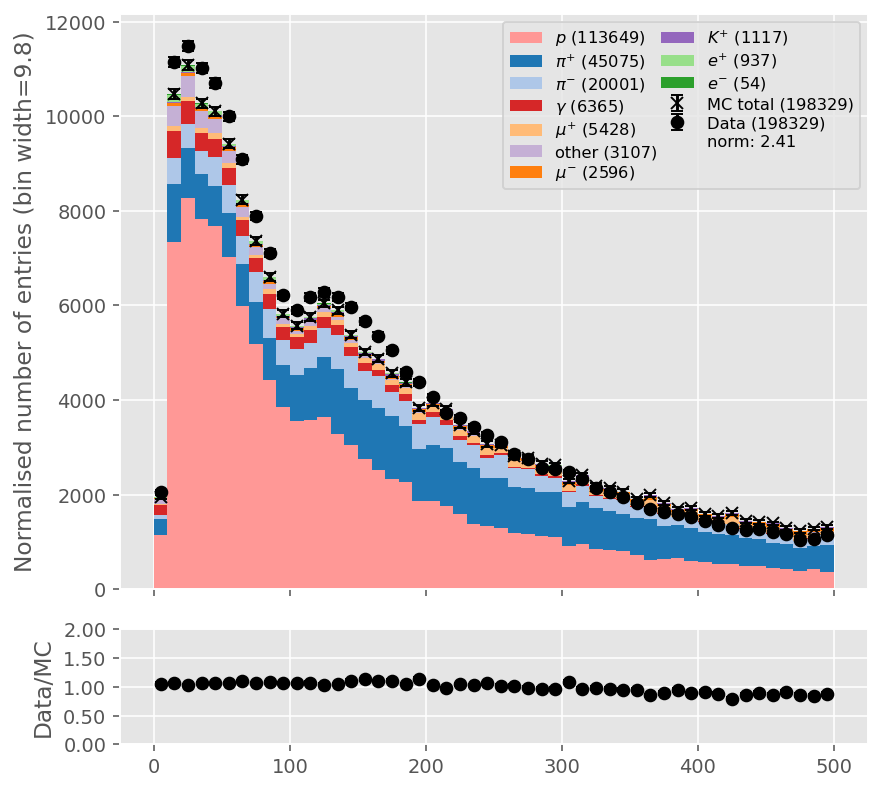

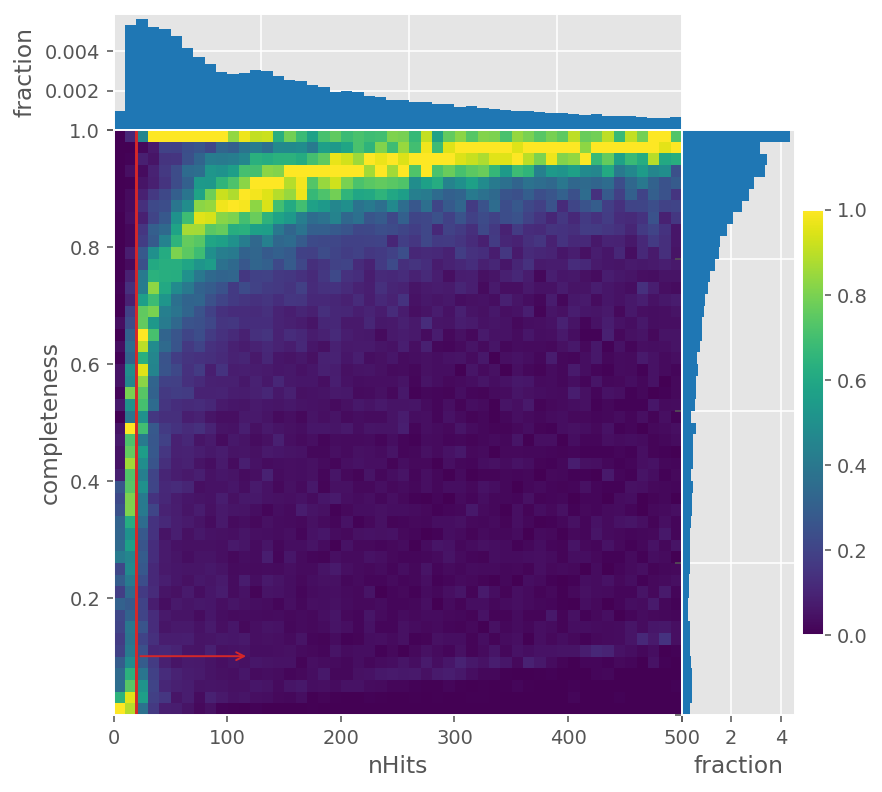

In [12]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, ncols = 2, x_range = [0, 500], norm = True)
# Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), xlabel = "completeness", ylabel = "nHits", y_range = [0, 500], bins = 50)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.nHits), ak.ravel(samples["mc"].trueParticlesBT.completeness), ylabel = "completeness", xlabel = "nHits", x_range = [0, 500], bins = 50, norm = "column", c_scale = "linear")
Plots.DrawCutPosition(20, arrow_length = 100, arrow_loc = 0.1, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1171: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1172: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


number of entries before|after PiPlusSelection: 94725|45586
number of entries before|after PiPlusSelection: 227140|104789


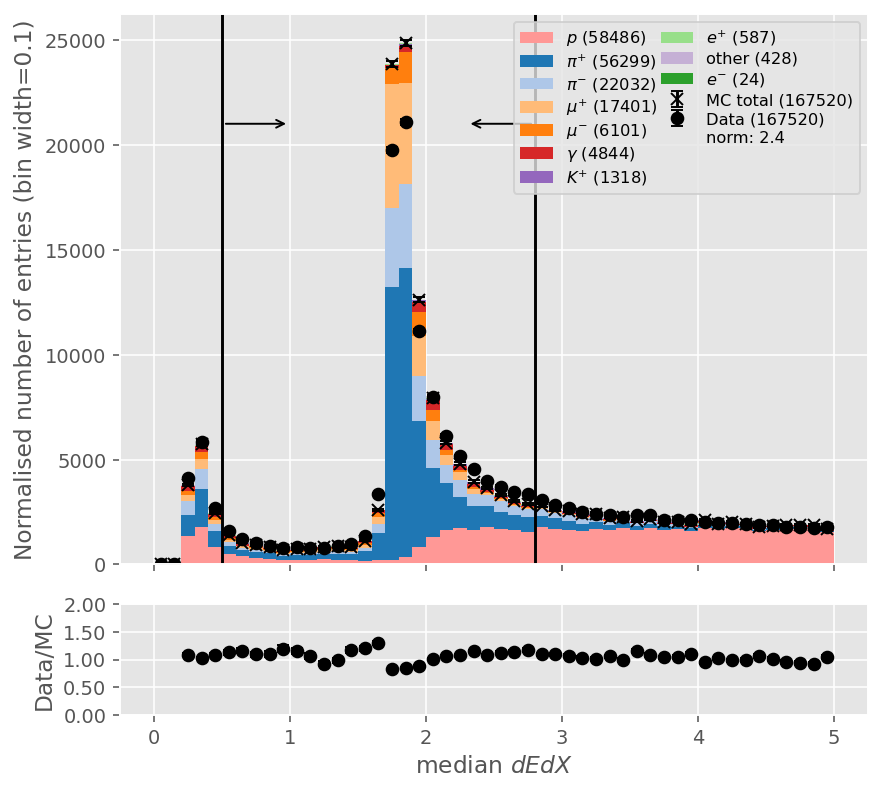

In [13]:
median_dEdX = {s : PFOSelection.Median(samples[s].recoParticles.track_dEdX) for s in samples}
Plots.PlotTagged(median_dEdX["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = median_dEdX["data"], ncols = 2, x_range = [0, 5], x_label = "median $dEdX$", bins = 50, norm = True)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

masks = {s : PFOSelection.PiPlusSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [310, 1285, 6731, 2205, 20268, 7211, 162, 7, 7337, 70])

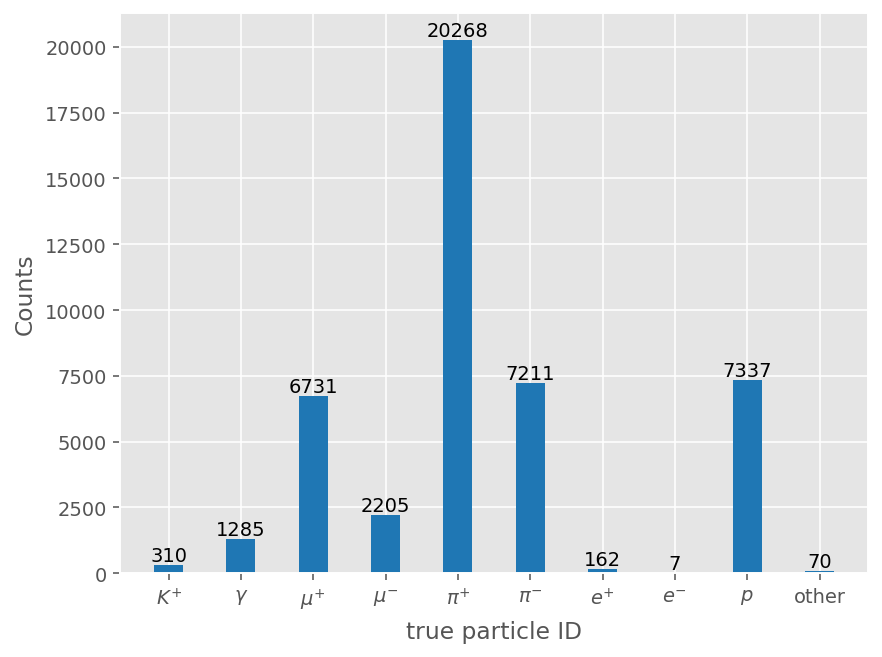

In [22]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")


# photon candidate selection

number of entries before|after EMScoreCut: 129147|43446
number of entries before|after EMScoreCut: 270282|102557


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/

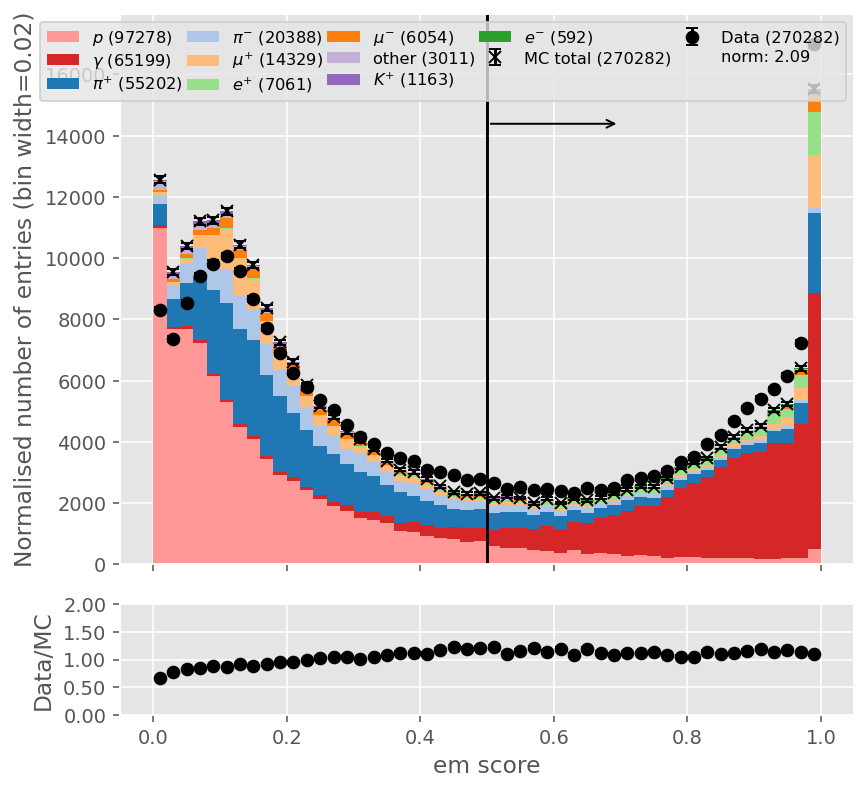

In [47]:
Plots.PlotTagged(samples["mc"].recoParticles.emScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.emScore, bins = 50, x_range = [0, 1], ncols = 5, x_label = "em score", norm = True)
Plots.DrawCutPosition(0.5)

masks = {s : PFOSelection.EMScoreCut(samples[s], 0.5) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 43446|21849
number of entries before|after NHitsCut: 102557|53490


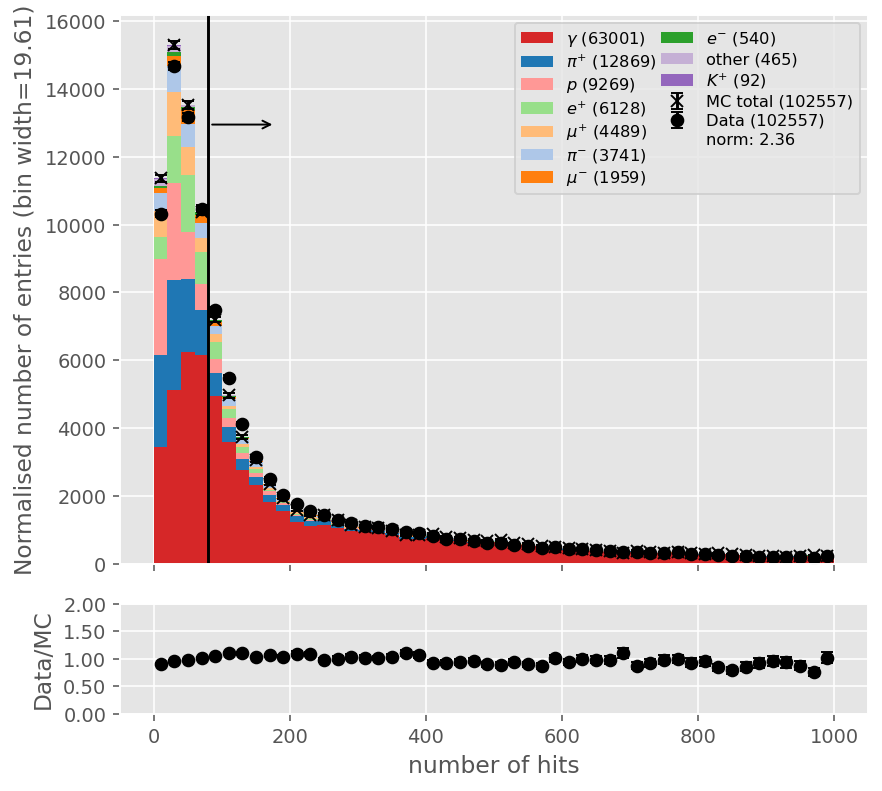

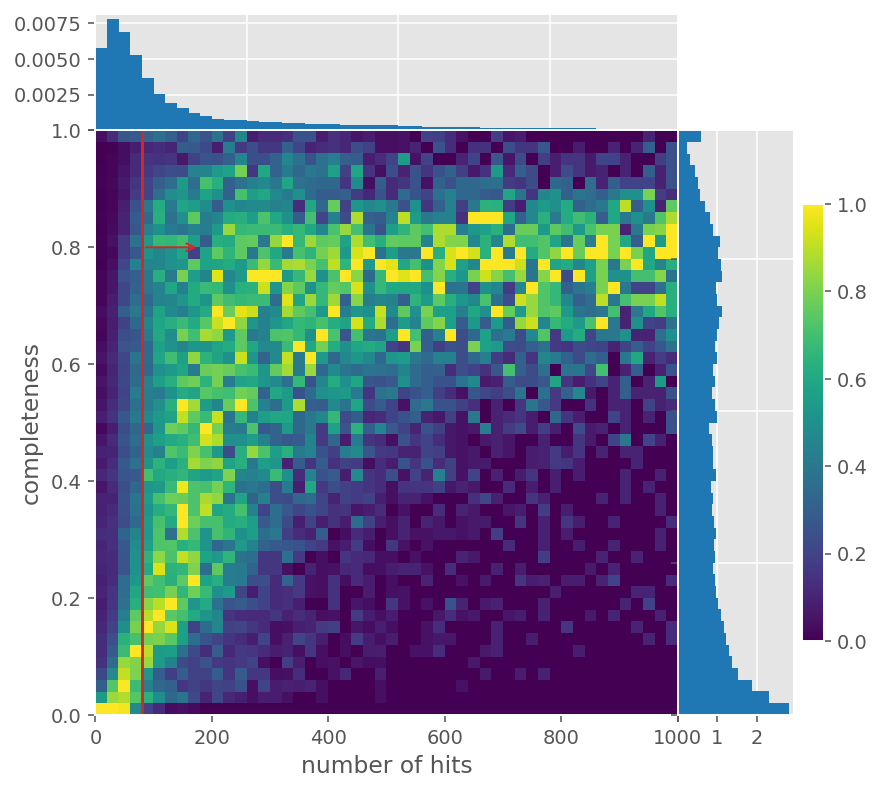

In [48]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, x_label = "number of hits", x_range = [0, 1000], norm = True)
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.nHits), ak.ravel(samples["mc"].trueParticlesBT.completeness), bins = 50, y_range = [0, 1],x_range = [0, 1000], ylabel = "completeness", xlabel = "number of hits", norm = "column")
Plots.DrawCutPosition(80, flip = False, arrow_length = 100, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 80) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after BeamParticleDistanceCut: 21849|17634
number of entries before|after BeamParticleDistanceCut: 53490|44134


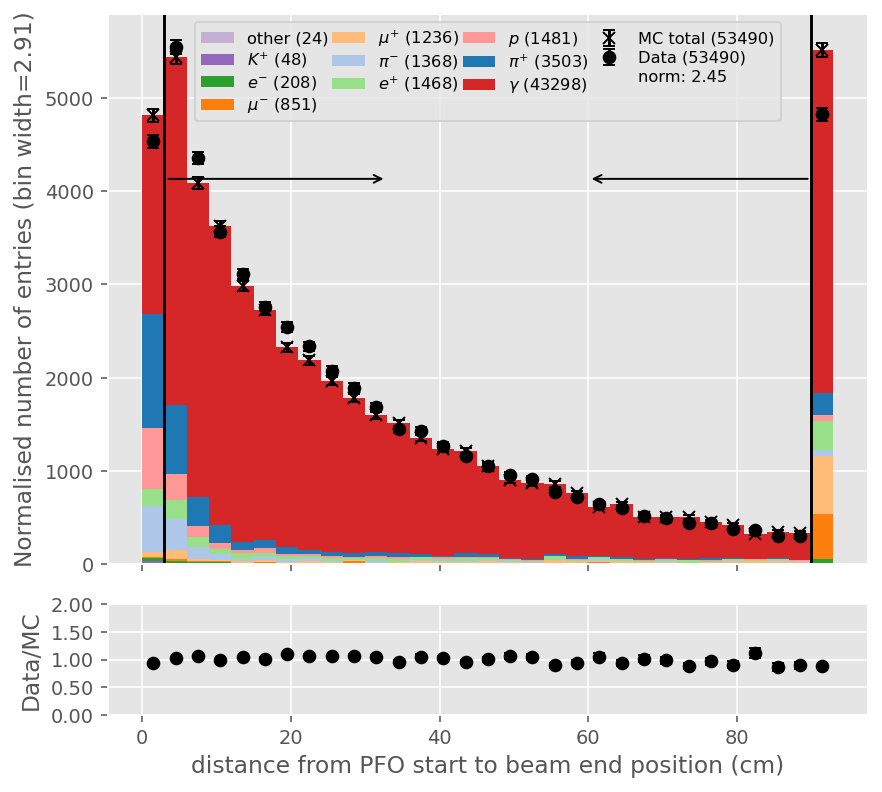

In [49]:
dist = {s : vector.dist(samples[s].recoParticles.startPos, samples[s].recoParticles.beam_endPos) for s in samples}

Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = dist["data"], bins = 31, x_range = [0, 93], x_label = "distance from PFO start to beam end position (cm)", ncols = 4, norm = True, stacked = "ascending", truncate = True)
Plots.DrawCutPosition(3, arrow_length = 30, arrow_loc = 0.7)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30, arrow_loc = 0.7)

masks = {s : PFOSelection.BeamParticleDistanceCut(samples[s], [3, 90]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after BeamParticleIPCut: 17634|13795
number of entries before|after BeamParticleIPCut: 44134|34663


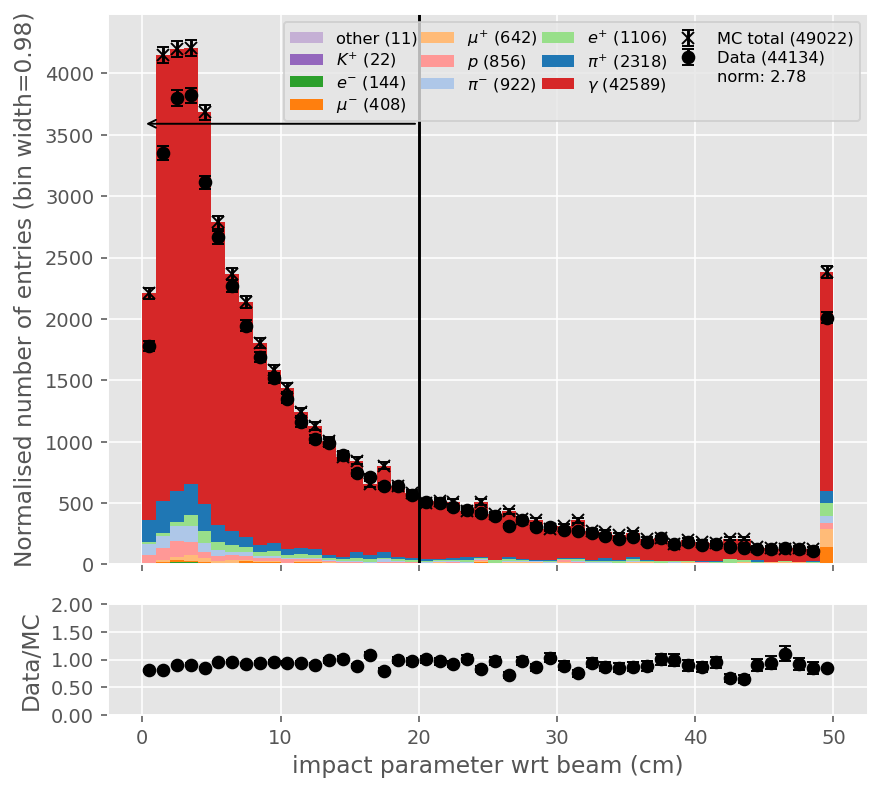

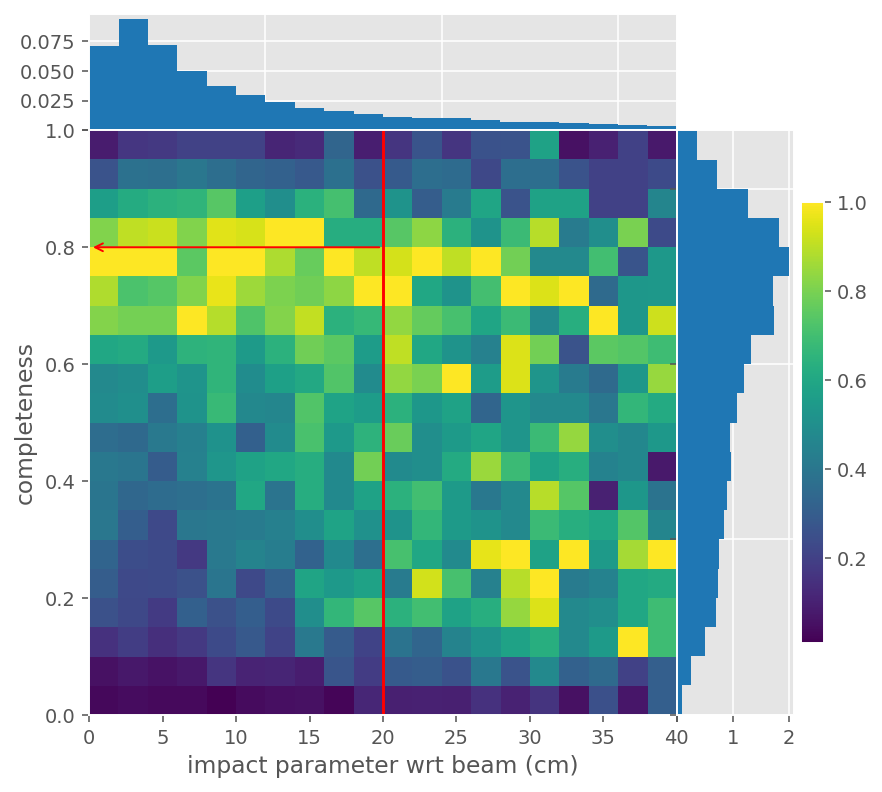

In [51]:
ip = {s : PFOSelection.find_beam_impact_parameters(samples[s]) for s in samples}

Plots.PlotTagged(ip["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = ip["data"], x_range = [0, 50], bins = 50, x_label = "impact parameter wrt beam (cm)", norm = args.norm, stacked = "ascending", ncols = 4, truncate = True)
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2DImshowMarginal(ak.ravel(ip["mc"]), ak.ravel(samples["mc"].trueParticlesBT.completeness), x_range = [0, 40], y_range = [0, 1], bins = 20, norm = "column", c_scale = "linear", ylabel = "completeness", xlabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_length = 20, face = "left", color = "red")

masks = {s : PFOSelection.BeamParticleIPCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)


(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [8, 12113, 106, 40, 708, 274, 251, 41, 252, 2])

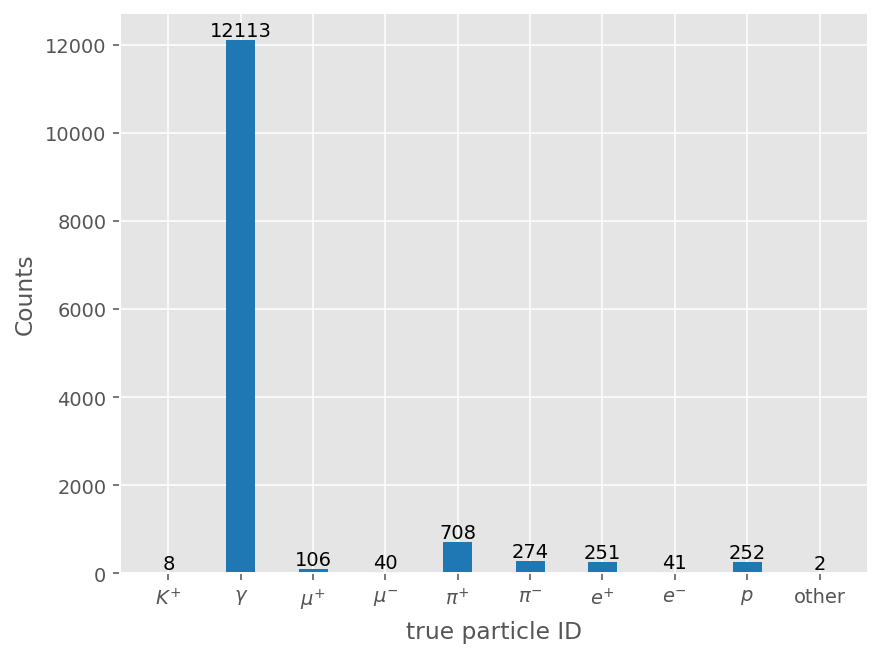

In [52]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

# $\pi^{0}$ selection

In [18]:
samples["mc"].cutTable.get_table()
print(samples["mc"].cutTable.get_masks()[0])
print(samples["mc"].cutTable._signatures)
print(samples["mc"].cutTable._end_sig)

print(len(samples["mc"].cutTable.get_masks()[0][-1]))
print(ak.count(samples["mc"].cutTable.get_masks()[0][-1]))
print(ak.sum(samples["mc"].cutTable.get_masks()[0][-1]))

[
    <Array [True, True, False, ... False, True] type='1000 * bool'>,
    <Array [True, True, False, ... True, True] type='598 * bool'>,
    <Array [True, True, True, ... True, True, True] type='528 * bool'>,
    <Array [True, True, True, ... True, True] type='514 * bool'>,
    <Array [True, True, True, ... True, True, True] type='420 * bool'>,
    <Array [True, True, True, ... True, True, True] type='382 * bool'>,
    <Array [True, True, False, ... True, True] type='367 * bool'>,
    <Array [True, True, True, ... True, True, True] type='317 * bool'>,
    <Array [True, True, True, ... True, True, True] type='305 * bool'>,
    <Array [True, True, False, ... True, True] type='239 * bool'>,
    <Array [[True, True], ... [True, True]] type='209 * var * bool'>
]

[
    (1000, -1),
    (598, -1),
    (528, -1),
    (514, -1),
    (420, -1),
    (382, -1),
    (367, -1),
    (317, -1),
    (305, -1),
    (239, -1),
    (209, 452)
]

(209, 399)

209

452

399

In [19]:
# samples["mc"].cutTable._get_mask_signature(mask = samples["mc"].cutTable.get_masks()[0][-1], end = True)
mask = samples["mc"].cutTable.get_masks()[0][-1]
print(mask)
flat_array = isinstance(ak.count(mask, axis=0), int)
curr_simul_masks = samples["mc"].cutTable._group_masks(rcount=1)
mask = curr_simul_masks[0]
for m in curr_simul_masks[1:]:
    mask = mask[m]
if flat_array:
    end_sig = (ak.num(mask, axis=0), -1)
else:
    end_sig = (ak.num(mask, axis=0), ak.sum(mask))
print(end_sig)

print(curr_simul_masks)
# print(mask)
print(flat_array)

[[True, True], [True, True], [True, ... [True, True, True, False], [True, True]]

(209, 399)

[<Array [[True, True], ... [True, True]] type='209 * var * bool'>]

False

In [20]:
photonCandidates = {s : PFOSelection.InitialPi0PhotonSelection(samples[s]) for s in samples}

number of entries before|after EMScoreCut: 399|130
number of entries before|after NHitsCut: 399|215
number of entries before|after BeamParticleDistanceCut: 399|166
number of entries before|after BeamParticleIPCut: 399|345
number of entries before|after VetoBeamParticle: 399|399
number of entries before|after EMScoreCut: 232|97
number of entries before|after NHitsCut: 232|133
number of entries before|after BeamParticleDistanceCut: 232|121
number of entries before|after BeamParticleIPCut: 232|188
number of entries before|after VetoBeamParticle: 232|232


209

209

5

end=False
flat_array=True
mask=<Array [False, False, False, ... False, False] type='209 * bool'>
end=True
flat_array=True
mask=<Array [False, False, False, ... False, False] type='209 * bool'>
mask=<Array [[True, True, True, ... [True, True]] type='5 * var * bool'>
end_sig=(5, -1)
end=False
flat_array=True
mask=<Array [False, True, False, ... False, False] type='115 * bool'>
end=True
flat_array=True
mask=<Array [False, True, False, ... False, False] type='115 * bool'>
mask=<Array [[True, True, True, ... True, True]] type='2 * var * bool'>
end_sig=(2, -1)


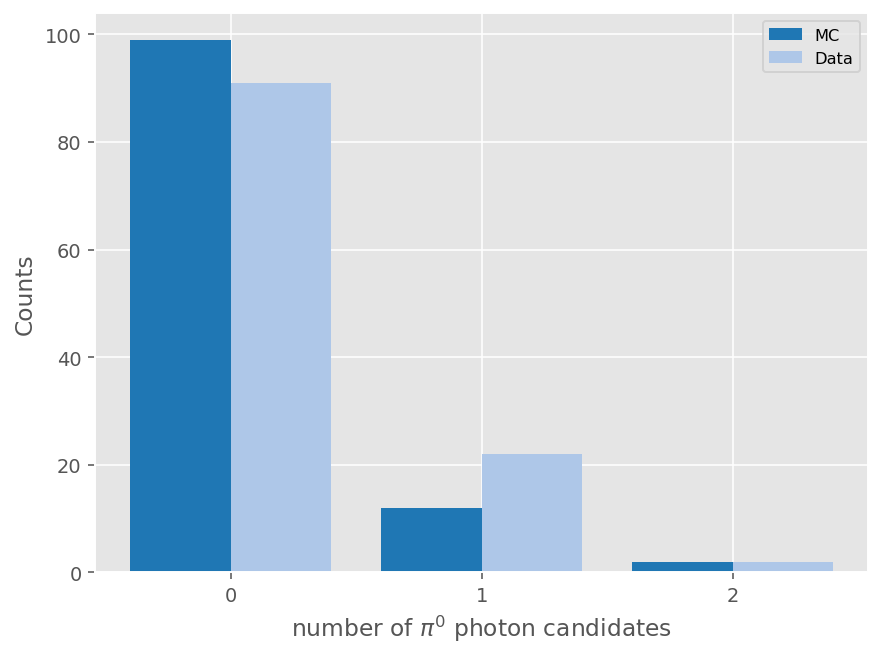

In [21]:
n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}

scale = ak.count(n_photons["data"]) / ak.count(n_photons["mc"])

n_photons_scaled = []
u, c = np.unique(n_photons["mc"], return_counts = True)
for i, j in zip(u, c):
    n_photons_scaled.extend([i]* int(scale * j))

Plots.PlotBarComparision(n_photons_scaled, n_photons["data"], xlabel = "number of $\pi^{0}$ photon candidates", label_1 = "MC", label_2 = "Data", barlabel = False)

masks = {s : n_photons[s] == 2 for s in samples}

print(len(masks["mc"]))
print(ak.count(masks["mc"]))
print(ak.sum(masks["mc"]))


FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

no truth information found, sorting showers by reco energy instead

{
    'mc': <Array [[220], [233], [156], [4.78], [185]] type='5 * var * float64'>,
    'data': <Array [[86], [232]] type='2 * var * float64'>
}

some tags do not have colours, will override them for the default ones


5

5

4

end=False
flat_array=True
mask=<Array [True, True, True, False, True] type='5 * bool'>
end=True
flat_array=True
mask=<Array [True, True, True, False, True] type='5 * bool'>
mask=<Array [True, True, True, False, True] type='5 * bool'>
end_sig=(4, -1)
end=False
flat_array=True
mask=<Array [True, True] type='2 * bool'>
end=True
flat_array=True
mask=<Array [True, True] type='2 * bool'>
mask=<Array [True, True] type='2 * bool'>
end_sig=(2, -1)


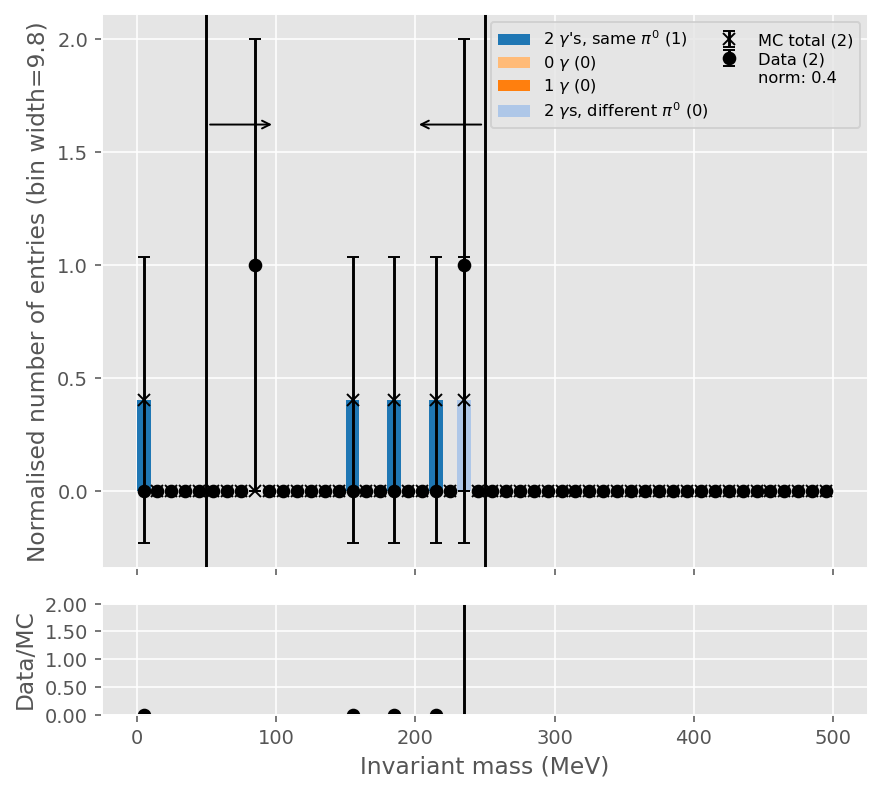

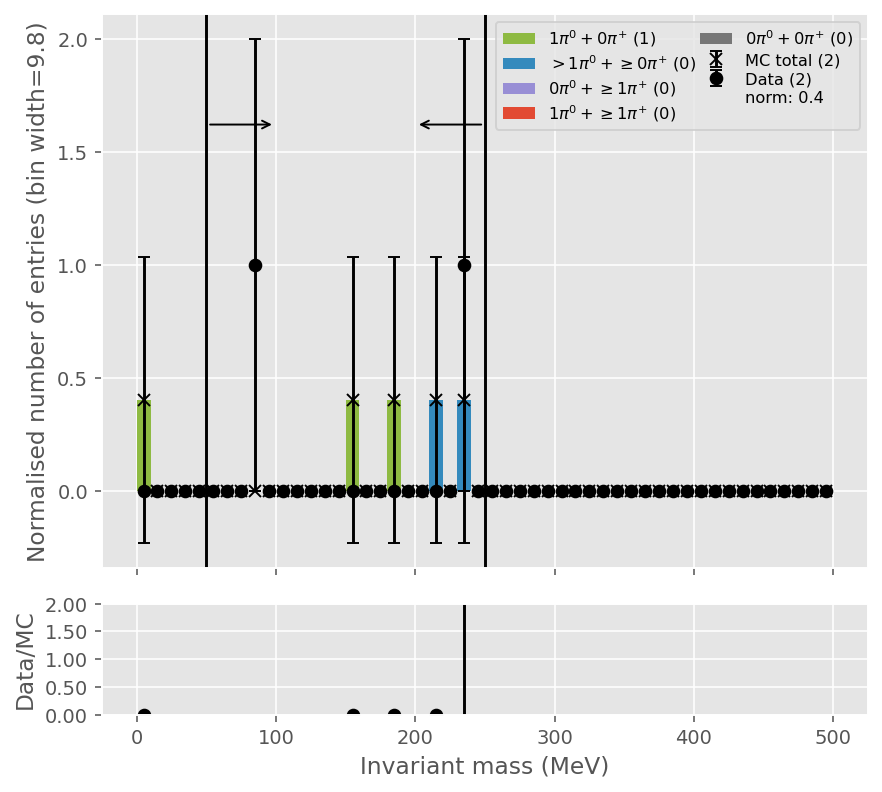

In [23]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

#* energy correction
correction_function = cross_section.EnergyCorrection.shower_energy_correction[args.correction]

with open(args.correction_params, "r") as f:
    correction_params = json.load(f)

e0 = {s : correction_function(shower_pairs[s].reco_lead_energy, **correction_params) for s in samples}
e1 = {s : correction_function(shower_pairs[s].reco_sub_energy, **correction_params) for s in samples}

mass = {s : Master.ShowerPairs.Mass(e0[s], e1[s], shower_pairs[s].reco_angle) for s in samples}
mass = {s : ak.fill_none(ak.pad_none(mass[s], 1, -1), -999, -1) for s in samples}
print(mass)

# mask = (mass > 50) & (mass < 250)
# mask = ak.flatten(mask) # 1 pi0


Plots.PlotTagged(mass["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass["mc"], EventSelection.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

masks = {s : ak.flatten((mass[s] > 50) & (mass[s] < 250)) for s in samples}

print(len(masks["mc"]))
print(ak.count(masks["mc"]))
print(ak.sum(masks["mc"]))

FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

In [24]:
df = samples["mc"].cutTable.get_table()
print(df.iloc[-1])

Name                                            -
Remaining events                              239
Percentage of total events remaining         23.9
Relative percentage events              78.360656
Remaining PFOs                                503
Percentage of total PFOs remaining      36.343931
Relative percentage of PFOs             80.223285
Average PFOs per event                   2.104603
Name: 9, dtype: object

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones
end=False
flat_array=True
mask=<Array [True, False, True, True] type='4 * bool'>
end=True
flat_array=True
mask=<Array [True, False, True, True] type='4 * bool'>
mask=<Array [True, False, True, True] type='4 * bool'>
end_sig=(3, -1)
end=False
flat_array=True
mask=<Array [True, False] type='2 * bool'>
end=True
flat_array=True
mask=<Array [True, False] type='2 * bool'>
mask=<Array [True, False] type='2 * bool'>
end_sig=(1, -1)


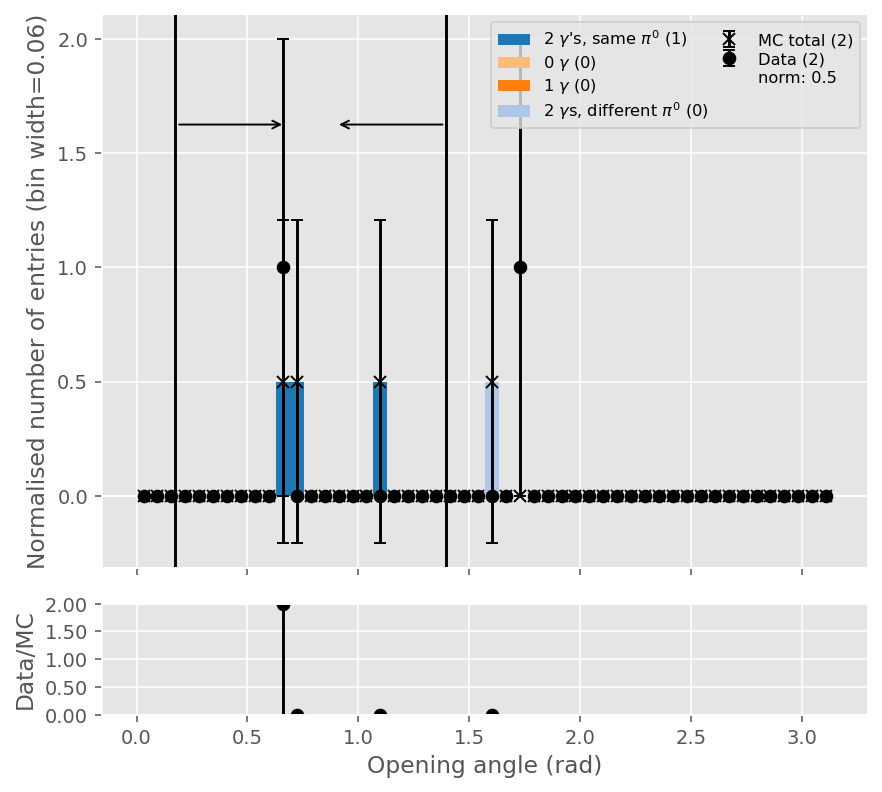

In [25]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

angle = {s : ak.flatten(shower_pairs[s].reco_angle) for s in samples}

Plots.PlotTagged(angle["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = angle["data"], bins = 50, x_label = "Opening angle (rad)", x_range = [0, np.pi], norm = True)
Plots.DrawCutPosition((10 * np.pi / 180), face = "right", arrow_length = 0.5)
Plots.DrawCutPosition((80 * np.pi / 180), face = "left", arrow_length = 0.5)

masks = {s : (angle[s] > (10 * np.pi / 180)) & (angle[s] < (80 * np.pi / 180)) for s in samples}
FilterSamples(samples, masks)
# photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

In [31]:
samples["mc"].cutTable.get_table()

# samples["mc"].cutTable._data_changed = True
# for f in samples["mc"].cutTable:
#     print(f(samples["mc"].cutTable._init_data))

# samples["mc"].cutTable.get_masks()

,Name,Remaining events,Percentage of total events remaining,Relative percentage events,Remaining PFOs,Percentage of total PFOs remaining,Relative percentage of PFOs,Average PFOs per event
0,Initial data,1000,100.0,100.000000,1384,100.000000,100.000000,1.384000
1,-,598,59.8,59.800000,1161,83.887283,83.887283,1.941472
2,-,528,52.8,88.294314,1136,82.080925,97.846684,2.151515
3,-,514,51.4,97.348485,1113,80.419075,97.975352,2.165370
4,-,420,42.0,81.712062,827,59.754335,74.303684,1.969048
5,-,382,38.2,90.952381,732,52.890173,88.512696,1.916230
6,-,367,36.7,96.073298,714,51.589595,97.540984,1.945504
7,-,317,31.7,86.376022,635,45.881503,88.935574,2.003155
8,-,305,30.5,96.214511,627,45.303468,98.740157,2.055738
9,-,239,23.9,78.360656,503,36.343931,80.223285,2.104603


In [26]:
event_topology_tags = EventSelection.GenerateTrueFinalStateTags(samples["mc"])

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))

exclusive signal 237 1921

background 350 1921

sideband 312 1921

sideband 904 1921

sideband 118 1921